<a href="https://colab.research.google.com/github/newton-c/haiti_monitoring/blob/main/ucdp_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
library(tidyverse) # data wrangling
library(httr) # call the api
library(jsonlite) # convert the JSON api response to a dataframe


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




### Get the last month's GED dataset
To automatically get the lastest data, we may run into two problems:

1. As the data are updated monthly, we need the version of the previous month. This is usually simple as we can take one away from the current month. But in January, we have to subtract from the year, and make the month 12.

2. If we call the API before the newest month is availibe, we'll get an error.
 To make it easier for those that are unfamiliar with the code, have the code return an error, but then try the previous month to see if the error is a result of asking for data that hasn't been updated yet, or if there is another
 connection error that need to be debugged. The `month` parameter in this
`def_version` function allows the later code to define the earlier month.

In [6]:
def_version <- function(month = NULL) {
  if (is.null(month)) {
    # for January, we need to go the December of the previous year
    if (as.numeric(format(Sys.Date(), "%m")) == 1) {
      year <- as.numeric(format(Sys.Date(), "%y")) - 1
      month <- 12
      version <- paste(year, 0, month, sep=".")
    } else {
      year <- format(Sys.Date(), "%y")
      month <- as.numeric(format(Sys.Date(), "%m")) - 1
      version <- paste(year, 0, month, sep=".")
    }
  } else if (!is.null(month)) {
    # for January, we need to go the December of the previous year
    if (month == 1) {
      year <- as.numeric(format(Sys.Date(), "%y")) - 1
      month <- 12
      version <- paste(year, 0, month, sep=".")
    } else {
      year <- format(Sys.Date(), "%y")
      month <- month
      version <- paste(year, 0, month, sep=".")
    }
  }
  return(version)
}

As of now, the only parameter changing in the API is the version of the dataset. This will likely change as we refine what we want to monitor.

In [7]:
def_url <- function(version) {
  url = paste0("https://ucdpapi.pcr.uu.se/api/",
              "gedevents",  "/",
              version, "?pagesize=1000&",
              "Country=41")
}

In [8]:
# get the version from last month
version <- def_version()
version

# define the API's URL
api_url <- def_url(version = version)
api_url

[1] "24.0.8"

[1] "https://ucdpapi.pcr.uu.se/api/gedevents/24.0.8?pagesize=1000&Country=41"

This code with will make the API request, assuming last month's data is the latest available. The code checks whether the connection was successful (`status_code` should be 200). If the connection is not successful, the code returns an error, printing the `status_code` (this can be looked up online to better understand what may be causing the problem), and then tries the API again with the versions from two months ago. If still unsucceful, the program prints the latest `status_code` and stops running.

In [9]:
# make the API request
api <- GET(api_url)

if (api$status_code != 200) {
  print(paste("Error: could not connect to the API | ",
              "Status: ", api$status_code,
              " | The latest month may not be availible. ",
              "Trying the previous month", sep = "\n"))

  # redefine the API call with the version from two months ago
  month <- as.numeric(format(Sys.Date(), "%m")) - 2
  version <- def_version(month = month)
  api_url <- def_url(version = version)
  api <- GET(api_url)
  if (api$status_code != 200) {
    stop(paste0("Error: Still cannot connect to the API | Status: ",
         api$status_code))
  } else {
    print(paste0("Conected successfully | Status: ", api$status_code))
  }
}

print(api)

Response [https://ucdpapi.pcr.uu.se/api/gedevents/24.0.8?pagesize=1000&Country=41]
  Date: 2024-09-27 23:32
  Status: 200
  Content-Type: application/json; charset=utf-8
  Size: 13.8 kB
{
  "TotalCount": 7,
  "TotalPages": 1,
  "PreviousPageUrl": null,
  "NextPageUrl": "",
  "Result": [
    {
      "id": 535457,
      "relid": "HAI-2024-1-1-XXX41-32",
      "year": 2024,
...


In [10]:
api_df = fromJSON(rawToChar(api$content))$Result # API to dataframe
print(colnames(api_df))
head(api_df)

 [1] "id"                "relid"             "year"             
 [4] "active_year"       "code_status"       "type_of_violence" 
 [7] "conflict_dset_id"  "conflict_new_id"   "conflict_name"    
[10] "dyad_dset_id"      "dyad_new_id"       "dyad_name"        
[13] "side_a_dset_id"    "side_a_new_id"     "side_a"           
[16] "side_b_dset_id"    "side_b_new_id"     "side_b"           
[19] "number_of_sources" "source_article"    "source_office"    
[22] "source_date"       "source_headline"   "source_original"  
[25] "where_prec"        "where_coordinates" "where_description"
[28] "adm_1"             "adm_2"             "latitude"         
[31] "longitude"         "geom_wkt"          "priogrid_gid"     
[34] "country"           "country_id"        "region"           
[37] "event_clarity"     "date_prec"         "date_start"       
[40] "date_end"          "deaths_a"          "deaths_b"         
[43] "deaths_civilians"  "deaths_unknown"    "best"             
[46] "high"              

,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,⋯,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnoa,gwnob
,<int>,<chr>,<int>,<lgl>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,⋯,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<lgl>,<lgl>
1,535457,HAI-2024-1-1-XXX41-32,2024,FALSE,Check dyad,1,XXX41,70,XXX41,1-XXX41,⋯,2024-08-11T00:00:00,0,7,0,0,7,7,7,NA,NA
2,539259,HAI-2024-1-1-XXX41-33,2024,FALSE,Check dyad,1,XXX41,70,XXX41,1-XXX41,⋯,2024-08-16T00:00:00,0,12,0,0,12,12,12,NA,NA
3,539262,HAI-2024-1-1-XXX41-34,2024,FALSE,Check dyad,1,XXX41,70,XXX41,1-XXX41,⋯,2024-08-28T00:00:00,1,0,0,0,1,1,1,NA,NA
4,539865,HAI-2024-1-1-XXX41-35,2024,FALSE,Check dyad,1,XXX41,70,XXX41,1-XXX41,⋯,2024-08-24T00:00:00,0,4,0,0,4,4,4,NA,NA
5,539867,HAI-2024-2-2-XXX41-27,2024,FALSE,Check dyad,2,2-XXX41,70,XXX41 - XXX41,2-XXX41,⋯,2024-08-15T00:00:00,0,0,0,1,1,1,1,NA,NA
6,539871,HAI-2024-3-3-XXX41-19,2024,FALSE,Check dyad,3,XXX41,4329,XXX41 - Civilians,XXX41,⋯,2024-08-11T00:00:00,0,0,1,0,1,1,1,NA,NA


### Most Violent Areas

**WARNING: We have to be carefull with all monitoring to check a lack of reported violence in an area is due to there not being violence, due to a lack of coverage, due to the violence not falling under a dataset's definition, or due to some other cause that could create a false sense of security**

In [11]:
api_df$events <- 1
events_adm2 <- api_df |>
  group_by(adm_2) |>
  summarise(events = sum(events, na.rm = FALSE))

deaths_adm2 <- api_df |>
  group_by(adm_2) |>
  summarise(total_deaths = sum(best, na.rm = FALSE))

civ_deaths_adm2 <- api_df |>
  group_by(adm_2) |>
  summarise(civilian_deaths = sum(deaths_civilians, na.rm = FALSE))

events_adm2
deaths_adm2
civ_deaths_adm2

adm_2,events
<chr>,<dbl>
Port-au-Prince arrondissement,6
Saint-Marc arrondissement,1


adm_2,total_deaths
<chr>,<int>
Port-au-Prince arrondissement,15
Saint-Marc arrondissement,12


adm_2,civilian_deaths
<chr>,<int>
Port-au-Prince arrondissement,2
Saint-Marc arrondissement,0


Mapping the violence

In [3]:
install.packages('maps')


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
system('sudo add-apt-repository ppa:ubuntugis/ubuntugis-unstable')
system('sudo apt-get update')
system('sudo apt-get install libudunits2-dev libgdal-dev libgeos-dev libproj-dev')
install.packages('sf')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘s2’




In [22]:
library(tidyverse)
library(maps)

map_df <- map_data("world") %>%
  select(long, lat, group, region, id = subregion)

data_labels <- tibble(x = c(-60, -50, -62, -65),
                      y = c(-22, -24.5, -28, -21),
                      label = c("Paraguay", "Brasil", "Argentina", "Bolivia"))

map <- ggplot() +
  geom_polygon(map_df, mapping = aes(long, lat, group = group),
               fill = ifelse(map_df$region == "Haiti",
                               "#E2E3E1", "#F3F3F3"),
               colour = ifelse(map_df$region == "Haiti",
                               "#3B3B3B", "#D0D1CF")) +
  theme_void() +
  theme(plot.background = element_rect(fill = "#F3F3F3"),
        panel.border = element_blank(),
        legend.position = "none",
        plot.title = ggplot2::element_text(family = "Roboto",
                                           face = "bold",
                                           size = 24,
                                           color = "#3B3B3B",
                                           hjust = 0),
        plot.subtitle = ggplot2::element_text(family = "Roboto",
                                              size = 19,
                                              color = "#3b3b3b",
                                              margin = ggplot2::margin(9, 0,
                                                                       20, 0),
                                              hjust = 0),
        plot.caption = ggplot2::element_blank(),
        plot.margin = margin(6, 6, 6, 6)) +
  coord_sf(xlim = c(-74.819018, -70.765063), ylim = c(17, 20)) +
  geom_point(api_df,
             mapping = aes(x = longitude, y = latitude),
                           fill = 'red',
             size = api_df$best,
             shape = 21,
             color = "#3B3B3B",
             fill = "#AFDDD4",
             stroke = .5,
             alpha = .3) +
  geom_point(api_df,
              mapping = aes(x = longitude, y = latitude),
                            fill = 'blue',
              size = api_df$deaths_civilians,
              shape = 21,
              color = "#3B3B3B",
              fill = "#AFDDD4",
              stroke = .5,
              alpha = .3) +
  geom_text(mapping = aes(x = -70, y = 17, label =
    "i\u200An\u200As\u200Ai\u200Ag\u200Ah\u200At\u200Ac\u200Ar\u200Ai\u200Am\u200Ae\u200A.\u200Ao\u200Ar\u200Ag"
     ),
    size = 3.5, family = "Noto Serif", fontface = "italic", color = "#a5a5a5") +
  geom_text(mapping = aes(x = -63, y = -29.2, label = "Fuente: Ministerio de Justicia, mayo de 2023"
  ),
  size = 3.5, family = "Roboto", color = "#a5a5a5") +
    labs(title = "  Las sobrepobladas cárceles de Paraguay\n  han favorecido el crimen organizado")


Warning message:
“Duplicated aesthetics after name standardisation: fill”
Warning message:
“Duplicated aesthetics after name standardisation: fill”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Roboto' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Roboto' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Roboto' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Serif' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Serif' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Roboto' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Roboto' not found in PostS

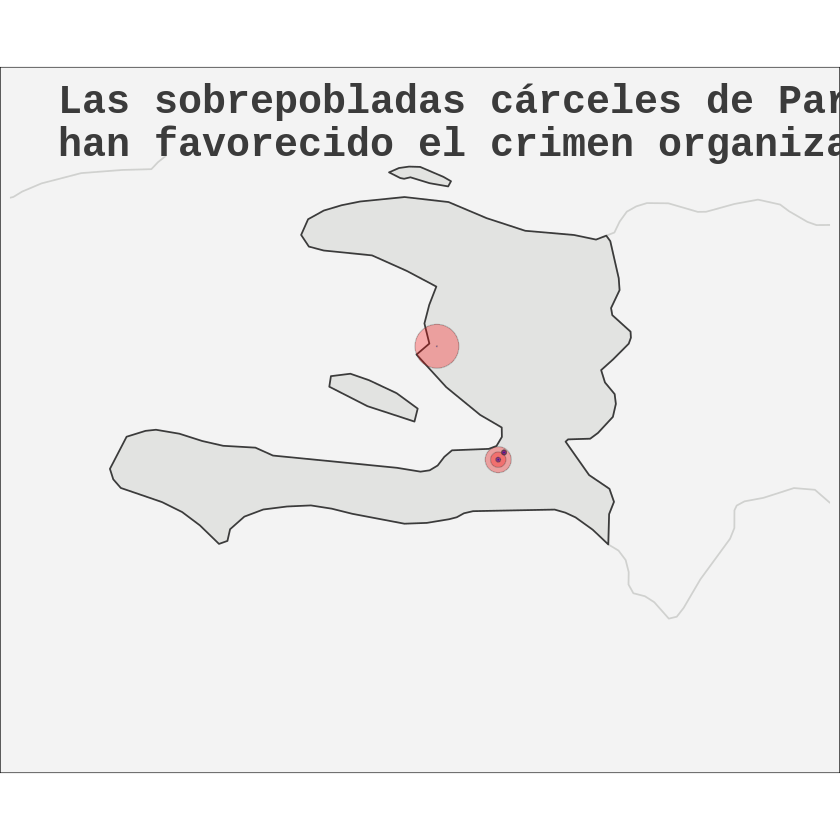

In [23]:
map